## Part 2. Biochemical Pathways and Groups in Phenotypic Description Data
The purpose of this notebook is to determine how well networks generated using phenotypic description based similarity measurements through a variety of embedding methods correlate with information about gene membership in biochemical pathways, or additionally in a arbitrary grouping such as functional categories as well. The theory this is based on is that because phenotypes are at some level the consequence of molecular or other lower level processes, two genes which are involved in a common process or pathway are more likely to impact a shared phenotype or at least two phenotypes that share more characteristics than what might be expected due to random chance.

In [1]:
import datetime
import nltk
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
import pandas as pd
import numpy as np
import time
import math
import sys
import gensim
import os
import warnings
import itertools
import multiprocessing as mp
from collections import Counter, defaultdict
from inspect import signature
from scipy.stats import ks_2samp
from sklearn.metrics import precision_recall_curve, f1_score, auc
from sklearn.model_selection import train_test_split, KFold
from scipy import spatial
from nltk.corpus import brown
from nltk.tokenize import word_tokenize
from sklearn.neighbors import KNeighborsClassifier

sys.path.append("../../oats")
from oats.utils.utils import save_to_pickle, load_from_pickle, merge_list_dicts, flatten, to_hms
from oats.datasets.dataset import Dataset
from oats.datasets.groupings import Groupings
from oats.annotation.ontology import Ontology
from oats.datasets.string import String
from oats.datasets.known import Known
from oats.annotation.annotation import annotate_using_rabin_karp, annotate_using_noble_coder
from oats.graphs.pairwise import pairwise_doc2vec_onegroup, pairwise_counting_onegroup, pairwise_annotations_onegroup
from oats.graphs.pairwise import merge_edgelists, subset_edgelist_with_ids, pairwise_word2vec_onegroup
from oats.graphs.pairwise import make_undirected
from oats.graphs.pairwise import remove_self_loops
from oats.graphs.indexed import IndexedGraph
from oats.graphs.models import train_logistic_regression_model, apply_logistic_regression_model
from oats.graphs.models import train_random_forest_model, apply_random_forest_model
from oats.nlp.vocabulary import get_overrepresented_tokens, build_vocabulary_from_tokens
from oats.utils.utils import function_wrapper_with_duration

mpl.rcParams["figure.dpi"] = 400
warnings.simplefilter('ignore')
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)
nltk.download('punkt')
nltk.download('brown')

[nltk_data] Downloading package punkt to /Users/irbraun/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package brown to /Users/irbraun/nltk_data...
[nltk_data]   Package brown is already up-to-date!


True

In [2]:
# Nested dictionary to summarize output with shape dict[method][(tag,metric)] --> value
# The dictionary is organized this way for printing within this notebook and saving as a csv file.
TAG = "biochemical pathways"
TABLE = defaultdict(dict)
OUTPUT_DIR = os.path.join("../outputs",datetime.datetime.now().strftime('%m_%d_%Y_h%Hm%Ms%S'))
os.mkdir(OUTPUT_DIR)

### 2.0 Defining all of the files and paths used in this notebook

In [3]:
dataset_filename = "../data/pickles/full_dataset.pickle"                       # The full dataset object.
groupings_filename = "../data/pickles/kegg_pathways.pickle"                    # The groupings object.
background_corpus_filename = "../data/corpus_related_files/background.txt"     # Text file with background content.
phenotypes_corpus_filename = "../data/corpus_related_files/phenotypes.txt"     # Text file with specific content.
doc2vec_model_filename = "../gensim/enwiki_dbow/doc2vec.bin"                   # File holding saved Doc2Vec model.
word2vec_model_filename = "../gensim/wiki_sg/word2vec.bin"                     # File holding saved Word2Vec model.
ontology_filename = "../ontologies/mo.obo"                                     # Ontology file in OBO format.
noblecoder_jarfile_path = "../lib/NobleCoder-1.0.jar"                          # File for NOBLE Coder annotation.

### 2.1 Reading in dataset and subsetting based on membership in biochemical pathways
The dataset can be loaded from an existing dataset object that was saved as a pickle, or csv files can be loaded directly into a new dataset object. Subsetting here is done so that only genes which are mapped to atleast one of the categories from whatever groupings are being used (such as biochemical pathways) are retained. Any other filtering to reduce the number of genes present in the dataset can be done at this point.

In [4]:
# Reading in the entire dataset, subsetting for species and desired annotation types.
dataset = load_from_pickle(dataset_filename)
dataset.describe()
dataset.collapse_by_all_gene_names()
dataset.filter_has_description()
dataset.filter_by_species("ath")
dataset.describe()

Number of rows in the dataframe: 47151
Number of unique IDs:            47151
Number of unique descriptions:   16504
Number of unique gene name sets: 47151
Number of species represented:   6
Number of rows in the dataframe: 6030
Number of unique IDs:            6030
Number of unique descriptions:   3665
Number of unique gene name sets: 6030
Number of species represented:   1


In [5]:
# Subsetting the dataset to include only those genes that map to at least one group from some classification source.
groups = load_from_pickle(groupings_filename)
id_to_group_ids = groups.get_id_to_group_ids_dict(dataset.get_gene_dictionary())
group_id_to_ids = groups.get_group_id_to_ids_dict(dataset.get_gene_dictionary())
group_mapped_ids = [k for (k,v) in id_to_group_ids.items() if len(v)>0]
groups.describe()

Number of groups present for each species
  ath: 627
  zma: 565
  mtr: 520
  osa: 569
  gmx: 618
  sly: 524
Number of genes names mapped to any group for each species
  ath: 9959
  zma: 14319
  mtr: 14100
  osa: 12156
  gmx: 20677
  sly: 13232


In [6]:
# Generate a table describing how many of the genes input from each species map to atleast one group.
summary = defaultdict(dict)
species_dict = dataset.get_species_dictionary()
for species in dataset.get_species():
    summary[species]["input"] = len([x for x in dataset.get_ids() if species_dict[x]==species])
    summary[species]["mapped"] = len([x for x in group_mapped_ids if species_dict[x]==species])
table = pd.DataFrame(summary).transpose()
table.loc["total"]= table.sum()
table["fraction"] = table.apply(lambda row: "{:0.4f}".format(row["mapped"]/row["input"]), axis=1)
table.to_csv(os.path.join(OUTPUT_DIR,"mappings_summary.csv"))


# Generate a table describing how many genes from each species map to which particular group.
summary = defaultdict(dict)
for group_id,ids in group_id_to_ids.items():
    summary[group_id].update({species:len([x for x in ids if species_dict[x]==species]) for species in dataset.get_species()})
    summary[group_id]["total"] = len([x for x in ids])
table = pd.DataFrame(summary).transpose()
table = table.sort_values(by="total", ascending=False)
table = table.reset_index(inplace=False)
table = table.rename({"index":"pathway_id"}, axis="columns")
table["pathway_name"] = table["pathway_id"].map(groups.get_long_name)
table.loc["total"] = table.sum()
table.loc["total","pathway_id"] = "total"
table.loc["total","pathway_name"] = "total"
table = table[table.columns.tolist()[-1:] + table.columns.tolist()[:-1]]
table.to_csv(os.path.join(OUTPUT_DIR,"mappings_by_group.csv"), index=False)

In [7]:
# Filter the dataset based on whether or not the genes were successfully mapped to a group.
dataset.filter_with_ids(group_mapped_ids)
dataset.filter_random_k(150)
dataset.describe()

Number of rows in the dataframe: 150
Number of unique IDs:            150
Number of unique descriptions:   137
Number of unique gene name sets: 150
Number of species represented:   1


In [8]:
# Get the mappings in each direction again now that the dataset has been subset.
id_to_group_ids = groups.get_id_to_group_ids_dict(dataset.get_gene_dictionary())
group_id_to_ids = groups.get_group_id_to_ids_dict(dataset.get_gene_dictionary())

### 2.2 Preprocessing of text descriptions, generating vocabularies, and other optional steps
Add some description for the different things that are done here. Some of these take a long time to run only load or run the parts which are used to generate the pairwise similarity networks in the subsequent cell.

In [9]:
# Constructing a vocabulary by looking at what words are overrepresented in domain specific text.
background_corpus = open(background_corpus_filename,"r").read()
phenotypes_corpus = open(phenotypes_corpus_filename,"r").read()
tokens = get_overrepresented_tokens(phenotypes_corpus, background_corpus, max_features=2000)
vocabulary_from_text = build_vocabulary_from_tokens(tokens)

# Constructing a vocabulary by assuming all words present in a given ontology are important.
ontology = Ontology(ontology_filename)
vocabulary_from_ontology = build_vocabulary_from_tokens(ontology.get_tokens())

# Loading other necessary objects or models and annotating text with ontology terms.
doc2vec_model = gensim.models.Doc2Vec.load(doc2vec_model_filename)
word2vec_model = gensim.models.Word2Vec.load(word2vec_model_filename)
descriptions = dataset.get_description_dictionary()
annotations_from_dataset = dataset.get_annotations_dictionary()
#annotations_rabin_karp = annotate_using_rabin_karp(descriptions, ontology)
annotations_noblecoder_precise = annotate_using_noble_coder(descriptions, noblecoder_jarfile_path, "mo", precise=1)
annotations_noblecoder_partial = annotate_using_noble_coder(descriptions, noblecoder_jarfile_path, "mo", precise=0)

# Generating random descriptions that are drawn from same token population and retain original lengths.
#tokens = [w for w in itertools.chain.from_iterable(word_tokenize(desc) for desc in descriptions.values())]
#scrambled_descriptions = {k:" ".join(np.random.choice(tokens,len(word_tokenize(v)))) for k,v in descriptions.items()}

### 2.3 Generating vector representations, pairwise similarity matrices, and edgelists
This includes things like whether or not to do capitilization removal, lemmatization, stemming, etc. on the descriptions present in the dataset. This could also included things like scrambling the contexts of each description to establish a baseline performance measure. This could also include things like reducing the vocabulary size through the preprocessing methods given here but also through additional means such as provided a reduced (more specialized) vocabulary dictionary to the vectorizing functions so that only those words which are most likely to have meaning have positions with those vectors. Should also test other vectorization methods such as term-frequency inverse-document-frequency for weighting. Can also change how the feature selection is done for those vectors by altering whether the *n*-grams are based on word or characters, and what the range of *n* is. Also should add the thing about combining the term annotations are text into a single bag-of-words vector representation.

In [10]:
# Generating the pairwise edgelists for each method.
#graphs = {} # A mapping between method names and graph objects containing edgelists and vector mappings.
#graphs["doc2vec"] = pairwise_doc2vec_onegroup(doc2vec_model, descriptions, metric="cosine")
#graphs["bagofwords"] = pairwise_counting_onegroup(descriptions, binary=False, metric="cosine", max_features=5000) 
#graphs["ngram_word"] = pairwise_counting_onegroup(descriptions, metric="cosine", binary=False, analyzer="word", ngram_range=(1,2), max_features=5000)
#graphs["ngram_char"] = pairwise_counting_onegroup(descriptions, metric="cosine", binary=False, analyzer="char", ngram_range=(4,6), max_features=5000)
#graphs["setofwords"] = pairwise_counting_onegroup(descriptions, binary=True, metric="jaccard")
#graphs["annot_rabk"] = pairwise_annotations_onegroup(annotations_rabin_karp, ontology, binary=True, metric="cosine")
#graphs["annot_ncpr"] = pairwise_annotations_onegroup(annotations_noblecoder_precise, ontology, binary=True, metric="cosine")
#graphs["annot_ncpa"] = pairwise_annotations_onegroup(annotations_noblecoder_partial, ontology, binary=True, metric="cosine")
#graphs["wrd2vec_avg"] = pairwise_word2vec_onegroup(word2vec_model, descriptions, metric="cosine", method="mean")
#graphs["wrd2vec_max"] = pairwise_word2vec_onegroup(word2vec_model, descriptions, metric="cosine", method="max")
#graphs["bag_pubmed"] = pairwise_counting_onegroup(descriptions, binary=False, metric="cosine", max_features=5000, vocabulary=vocabulary_from_text) 
#graphs["set_pubmed"] = pairwise_counting_onegroup(descriptions, binary=True, metric="cosine", max_features=5000, vocabulary=vocabulary_from_text)
#graphs["bag_ontvoc"] = pairwise_counting_onegroup(descriptions, binary=False, metric="cosine", max_features=5000, vocabulary=vocabulary_from_ontology) 
#graphs["set_ontvoc"] = pairwise_counting_onegroup(descriptions, binary=True, metric="cosine", max_features=5000, vocabulary=vocabulary_from_ontology)
#print("{} methods completed".format(len(graphs)))

In [11]:
# Generating the pairwise edgelists for each method, multiprocessing verion.
name_function_args_tuples = [
    ("doc2vec", pairwise_doc2vec_onegroup, {"model":doc2vec_model, "object_dict":descriptions, "metric":"cosine"}),
    ("bagofwords", pairwise_counting_onegroup, {"object_dict":descriptions, "metric":"cosine", "binary":False, "max_features":5000}),
    ("ngram_word", pairwise_counting_onegroup, {"object_dict":descriptions, "metric":"cosine", "binary":False, "analyzer":"word", "ngram_range":(1,2), "max_features":5000}),
    ("ngram_char", pairwise_counting_onegroup, {"object_dict":descriptions, "metric":"cosine", "binary":False, "analyzer":"char", "ngram_range":(4,6), "max_features":5000}),
    ("setofwords", pairwise_counting_onegroup, {"object_dict":descriptions, "metric":"jaccard", "binary":True, "max_features":5000}),
    ("annot_ncpr", pairwise_annotations_onegroup, {"annotations_dict":annotations_noblecoder_precise, "ontology":ontology, "binary":True, "metric":"jaccard"}),
    ("annot_ncpa", pairwise_annotations_onegroup, {"annotations_dict":annotations_noblecoder_partial, "ontology":ontology, "binary":True, "metric":"jaccard"}),
    ("word2vec_avg", pairwise_word2vec_onegroup, {"model":word2vec_model, "object_dict":descriptions, "metric":"cosine", "method":"mean"}),
    ("word2vec_max", pairwise_word2vec_onegroup, {"model":word2vec_model, "object_dict":descriptions, "metric":"cosine", "method":"max"}),
    ("bag_pubmed", pairwise_counting_onegroup, {"object_dict":descriptions, "metric":"cosine", "binary":False, "max_features":5000, "vocabulary":vocabulary_from_text}),
    ("set_pubmed", pairwise_counting_onegroup, {"object_dict":descriptions, "metric":"cosine", "binary":True, "max_features":5000, "vocabulary":vocabulary_from_text}),
    ("bag_ontvoc", pairwise_counting_onegroup, {"object_dict":descriptions, "metric":"cosine", "binary":False, "max_features":5000, "vocabulary":vocabulary_from_ontology}),
    ("set_ontvoc", pairwise_counting_onegroup, {"object_dict":descriptions, "metric":"cosine", "binary":True, "max_features":5000, "vocabulary":vocabulary_from_ontology}),
]

In [12]:
# Generate all of the similarity matrices in parallel.
start_time_mp = time.perf_counter()
pool = mp.Pool(mp.cpu_count())
results = [pool.apply_async(function_wrapper_with_duration, args=(func, args)) for (name,func,args) in name_function_args_tuples]
results = [result.get() for result in results]
graphs = {tup[0]:result[0] for tup,result in zip(name_function_args_tuples,results)}
durations = {tup[0]:result[1] for tup,result in zip(name_function_args_tuples,results)}
pool.close()
pool.join()    
total_time_mp = time.perf_counter()-start_time_mp

# Reporting how long each matrix took to build and how much time parallel processing saved.
print("Durations of generating each pairwise similarity matrix (hh:mm:ss)")
print("-----------------------------------------------------------------")
savings = total_time_mp/sum(durations.values())
for (name,duration) in durations.items():
    print("{:15} {}".format(name, to_hms(duration)))
print("-----------------------------------------------------------------")
print("{:15} {}".format("total", to_hms(sum(durations.values()))))
print("{:15} {} ({:.2%} of single thread time)".format("multiprocess", to_hms(total_time_mp), savings))

Durations of generating each pairwise similarity matrix (hh:mm:ss)
-----------------------------------------------------------------
doc2vec         00:00:00
bagofwords      00:00:00
ngram_word      00:00:00
ngram_char      00:00:00
setofwords      00:00:00
annot_ncpr      00:00:00
annot_ncpa      00:00:00
word2vec_avg    00:00:00
word2vec_max    00:00:00
bag_pubmed      00:00:00
set_pubmed      00:00:00
bag_ontvoc      00:00:00
set_ontvoc      00:00:00
-----------------------------------------------------------------
total           00:00:02
multiprocess    00:00:46 (2129.83% of single thread time)


In [13]:
#graphs = {tup[0]:tup[1](**tup[2]) for tup in name_function_args_tuples}

In [14]:
# Merging all of the edgelist dataframes together.
methods = list(graphs.keys())
edgelists = {k:v.edgelist for k,v in graphs.items()}
df = merge_edgelists(edgelists, default_value=0.000)
df = remove_self_loops(df)
df.tail(10)

,from,to,doc2vec,bagofwords,ngram_word,ngram_char,setofwords,annot_ncpr,annot_ncpa,word2vec_avg,word2vec_max,bag_pubmed,set_pubmed,bag_ontvoc,set_ontvoc
11311,1213,2066,0.330688,0.751522,0.856379,0.447151,0.937500,0.400000,0.571429,2.020131e-01,0.614985,1.000000,1.000000,0.606758,0.795876
11312,1213,2027,0.406203,0.743968,0.852107,0.433973,0.933333,0.400000,0.571429,2.020131e-01,0.614985,1.000000,1.000000,0.615100,0.795876
11313,1213,14521,0.550224,1.000000,1.000000,0.990770,1.000000,0.918919,0.950820,4.279892e-01,0.304767,1.000000,1.000000,1.000000,1.000000
11314,1213,1956,0.614154,0.856413,0.914036,0.964280,0.981481,0.960000,0.962536,2.223211e-01,0.191749,0.945279,0.956356,0.766543,0.846907
11316,2066,2027,0.134222,0.209226,0.372979,0.242154,0.428571,0.000000,0.000000,6.328271e-15,0.000000,0.293494,0.329180,0.001031,0.000000
11317,2066,14521,0.533335,1.000000,1.000000,1.000000,1.000000,0.914286,0.881356,4.557108e-01,0.570282,1.000000,1.000000,1.000000,1.000000
11318,2066,1956,0.620368,0.866646,0.921591,0.969844,0.980892,0.952381,0.944606,3.987460e-01,0.683361,0.935985,0.896720,0.817802,0.812500
11320,2027,14521,0.613150,1.000000,1.000000,1.000000,1.000000,0.914286,0.881356,4.557108e-01,0.570282,1.000000,1.000000,1.000000,1.000000
11321,2027,1956,0.611426,0.862592,0.919259,0.968661,0.980769,0.952381,0.944606,3.987460e-01,0.683361,0.933236,0.884530,0.821667,0.812500
11323,14521,1956,0.493885,0.954209,0.969452,0.967196,0.987879,0.828947,0.881159,3.829088e-01,0.208472,0.977614,0.948360,1.000000,1.000000


### 2.4 Merging the edgelists with information about biochemical pathway membership and species

In [15]:
# Generate a column indicating whether or not the two genes have atleast one pathway in common.
df["common"] = df[["from","to"]].apply(lambda x: len(set(id_to_group_ids[x["from"]]).intersection(set(id_to_group_ids[x["to"]])))>0, axis=1)*1
print(Counter(df["common"].values))

Counter({0: 11050, 1: 125})


In [16]:
# Generate a column indicating whether or not the two genes are from the same species.
species_dict = dataset.get_species_dictionary()
df["same"] = df[["from","to"]].apply(lambda x: species_dict[x["from"]]==species_dict[x["to"]],axis=1)*1
print(Counter(df["same"].values))

Counter({1: 11175})


### 2.5 Training logistic regression or random forest models to combine multiple methods
The purpose of this section is to iteratively train models on subsections of the dataset using simple regression or machine learning approaches to predict a value from zero to one indicating indicating how likely is it that two genes share atleast one of the specified groups in common. The information input to these models is the distance scores provided by each method in some set of all the methods used in this notebook. The purpose is to see whether or not a function of these similarity scores specifically trained to the task of predicting common groupings is better able to used the distance metric information to report a score for this task.

In [17]:
# Iteratively create models for combining output values from multiple semantic similarity methods.
method = "logistic_regression"
splits = 12
kf = KFold(n_splits=splits, random_state=14271, shuffle=True)
df[method] = pd.Series()
for train,test in kf.split(df):
    lr_model = train_logistic_regression_model(df=df.iloc[train], predictor_columns=methods, target_column="common")
    df[method].iloc[test] = apply_logistic_regression_model(df=df.iloc[test], predictor_columns=methods, model=lr_model)
df[method] = 1-df[method]
methods.append(method)

In [18]:
# Iteratively create models for combining output values from multiple semantic similarity methods.
method = "random_forest"
splits = 2
kf = KFold(n_splits=splits, random_state=14271, shuffle=True)
df[method] = pd.Series()
for train,test in kf.split(df):
    rf_model = train_random_forest_model(df=df.iloc[train], predictor_columns=methods, target_column="common")
    df[method].iloc[test] = apply_random_forest_model(df=df.iloc[test],predictor_columns=methods, model=rf_model)
df[method] = 1-df[method]
methods.append(method)

### 2.6 Do the edges joining genes that share atleast one pathways come from a different distribution?
The purpose of this section is to visualize kernel estimates for the distributions of distance or similarity scores generated by each of the methods tested for measuring semantic similarity or generating vector representations of the phenotype descriptions. Ideally, better methods should show better separation betwene the distributions for distance values between two genes involved in a common specified group or two genes that are not. Additionally, a statistical test is used to check whether these two distributions are significantly different from each other or not, although this is a less informative measure than the other tests used in subsequent sections, because it does not address how useful these differences in the distributions actually are for making predictions about group membership.

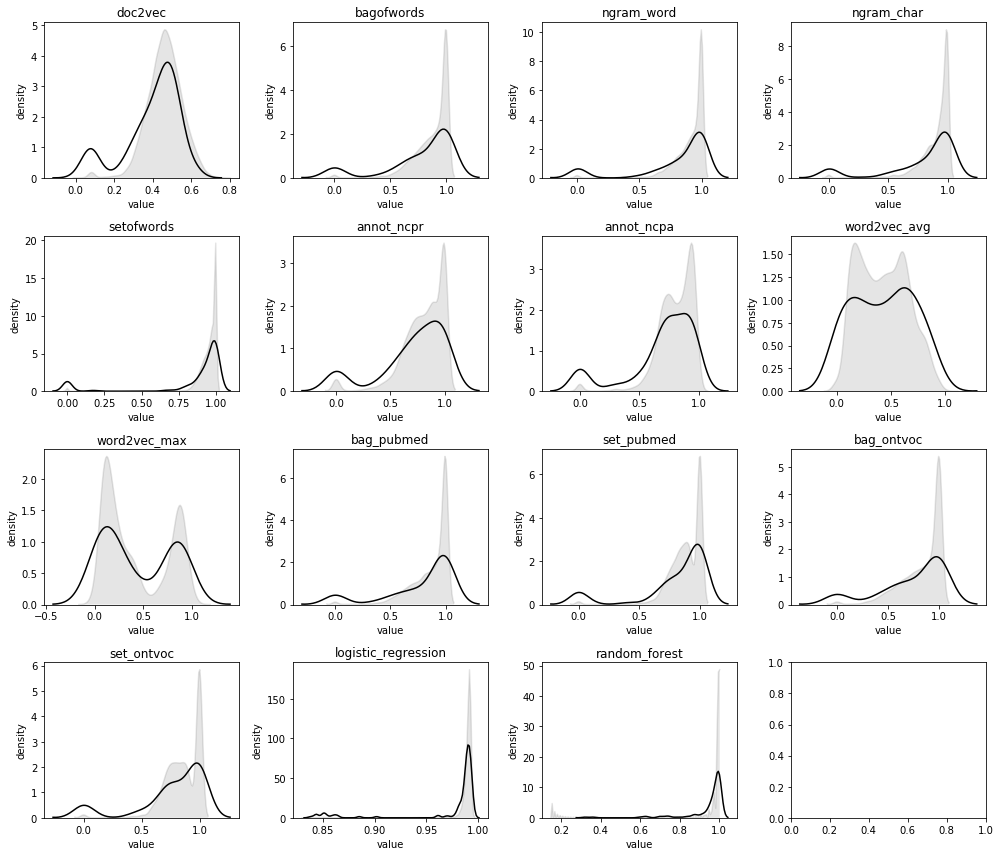

In [19]:
# Use Kolmogorov-Smirnov test to see if edges between genes that share a group come from a distinct distribution.
ppi_pos_dict = {name:(df[df["common"] > 0.00][name].values) for name in methods}
ppi_neg_dict = {name:(df[df["common"] == 0.00][name].values) for name in methods}
for name in methods:
    stat,p = ks_2samp(ppi_pos_dict[name],ppi_neg_dict[name])
    pos_mean = np.average(ppi_pos_dict[name])
    neg_mean = np.average(ppi_neg_dict[name])
    pos_n = len(ppi_pos_dict[name])
    neg_n = len(ppi_neg_dict[name])
    TABLE[name].update({(TAG,"mean_1"):pos_mean, (TAG,"mean_0"):neg_mean, (TAG,"n_1"):pos_n, (TAG,"n_0"):neg_n})
    TABLE[name].update({(TAG,"ks"):stat, (TAG,"ks_pval"):p})

# Show the kernel estimates for each distribution of weights for each method.
num_plots, plots_per_row, row_width, row_height = (len(methods), 4, 14, 3)
fig,axs = plt.subplots(math.ceil(num_plots/plots_per_row), plots_per_row, squeeze=False)
for name,ax in zip(methods,axs.flatten()):
    ax.set_title(name)
    ax.set_xlabel("value")
    ax.set_ylabel("density")
    sns.kdeplot(ppi_pos_dict[name], color="black", shade=False, alpha=1.0, ax=ax)
    sns.kdeplot(ppi_neg_dict[name], color="black", shade=True, alpha=0.1, ax=ax) 
fig.set_size_inches(row_width, row_height*math.ceil(num_plots/plots_per_row))
fig.tight_layout()
fig.show()
fig.savefig(os.path.join(OUTPUT_DIR,"kernel_density.png"))

### 2.7 Ranking each biochemical pathways by its phenotypic visibility
The purpose of this method is to look at which of the biochemical pathways (or whatever other arbitrary groupings) are the most easily recaptured using analysis of the text descriptions corresponding to the genes present in those biochemical pathways. This is done here by finding the average distance score for all the pairs of genes within each particular pathway or group for each method, then converting these values to ranks for ranking the pathways within a given method, then averaging the ranks across all methods. This is not necessarily extremely meaningful, if the pathway was involved in many phenotypes the pairwise similarity would not necessarily be very high, although the number of similar pairs might be higher than expected.

In [20]:
# Get all the average within-pathway phenotype similarity values for each method for each particular pathway.
group_id_to_ids = groups.get_group_id_to_ids_dict(dataset.get_gene_dictionary())
group_ids = list(group_id_to_ids.keys())
graph = IndexedGraph(df)
within_weights_dict = defaultdict(lambda: defaultdict(list))
all_weights_dict = {}
for method in methods:
    all_weights_dict[method] = df[method].values
    for group in group_ids:
        within_ids = group_id_to_ids[group]
        within_pairs = [(i,j) for i,j in itertools.permutations(within_ids,2)]
        within_weights_dict[method][group] = np.mean((graph.get_values(within_pairs, kind=method)))
heatmap_data = pd.DataFrame(within_weights_dict)
heatmap_data = heatmap_data.dropna(axis=0, inplace=False)
heatmap_data = heatmap_data.round(4).head(10)

In [21]:
# Find the average rank across methods of each pathway in terms of how low the mean within-group distance values were.
ranks = pd.DataFrame(within_weights_dict).rank()
ranks["average"] = ranks.mean(axis=1)
ranks.sort_values(by="average", inplace=True)
ranks.reset_index(inplace=True)
ranks["group_id"] = ranks["index"]
ranks["full_name"] = ranks["group_id"].apply(lambda x: groups.get_long_name(x))
ranks["n"] = ranks["group_id"].apply(lambda x: len(group_id_to_ids[x]))
ranks = ranks[["group_id", "n", "average","full_name",]]
ranks.head(20)

,group_id,n,average,full_name
0,PWY-5269,2,5.766667,cardiolipin biosynthesis II
1,PWY4FS-7,2,5.766667,phosphatidylglycerol biosynthesis I (plastidic)
2,PWY4FS-8,2,5.766667,phosphatidylglycerol biosynthesis II (non-plas...
3,PWY1F-FLAVSYN,3,6.766667,flavonoid biosynthesis
4,PWY-7398,3,6.766667,coumarins biosynthesis (engineered)
5,PWY-6982,3,6.766667,umbelliferone biosynthesis
6,PWY-5868,4,6.800000,simple coumarins biosynthesis
7,PWY-361,4,6.800000,phenylpropanoid biosynthesis
8,PWY-6457,2,7.166667,<i>trans</i>-cinnamoyl-CoA biosynthesis
9,PWY-6673,2,7.433333,caffeoylglucarate biosynthesis


### 2.8 Predicting whether two genes belong to a common biochemical pathway
The purpose of this section is to see if whether or not two genes share atleast one common pathway can be predicted from the similarity scores assigned using analysis of text similarity. The evaluation of predictability is done by reporting a precision and recall curve for each method, as well as remembering the area under the curve, and ratio between the area under the curve and the baseline (expected area when guessing randomly) for each method.

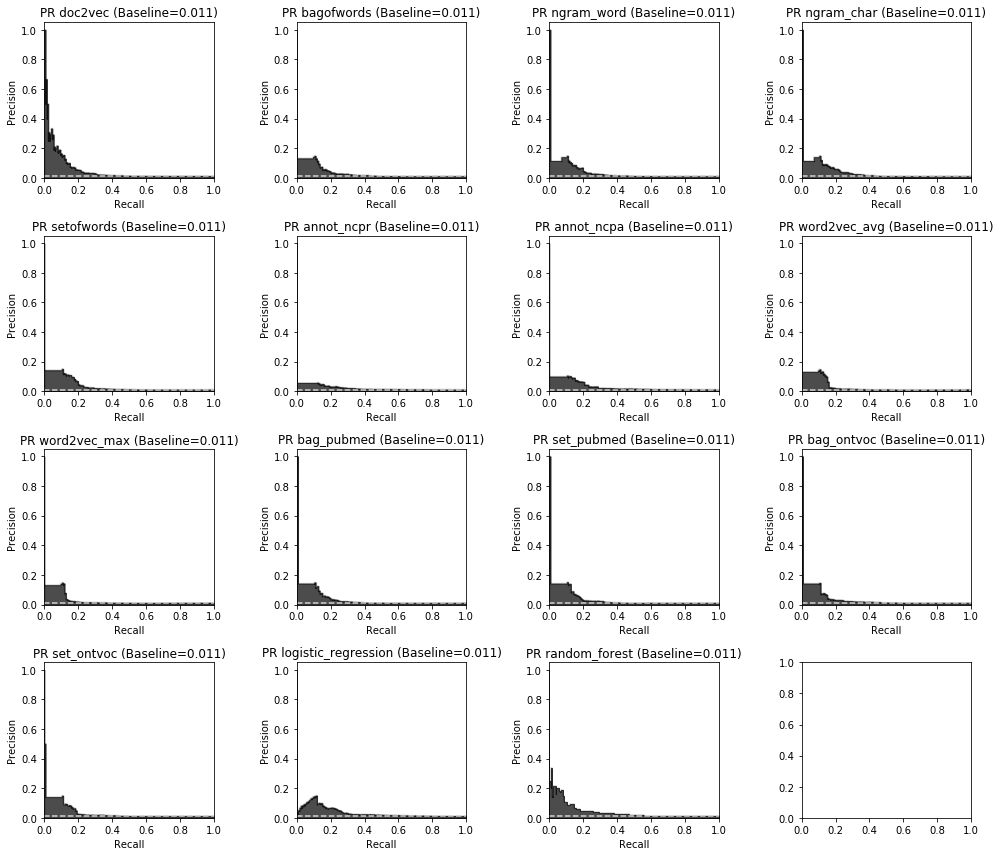

In [22]:
y_true_dict = {name:df["common"] for name in methods}
y_prob_dict = {name:(1 - df[name].values) for name in methods}
num_plots, plots_per_row, row_width, row_height = (len(methods), 4, 14, 3)
fig,axs = plt.subplots(math.ceil(num_plots/plots_per_row), plots_per_row, squeeze=False)
for method,ax in zip(methods, axs.flatten()):
    
    # Obtaining the values and metrics.
    y_true, y_prob = y_true_dict[method], y_prob_dict[method]
    n_pos, n_neg = Counter(y_true)[1], Counter(y_true)[0]
    precision, recall, thresholds = precision_recall_curve(y_true, y_prob)
    baseline = Counter(y_true)[1]/len(y_true) 
    area = auc(recall, precision)
    auc_to_baseline_auc_ratio = area/baseline
    TABLE[method].update({(TAG,"auc"):area, (TAG,"baseline"):baseline, (TAG,"ratio"):auc_to_baseline_auc_ratio})

    # Producing the precision recall curve.
    step_kwargs = ({'step': 'post'} if 'step' in signature(plt.fill_between).parameters else {})
    ax.step(recall, precision, color='black', alpha=0.2, where='post')
    ax.fill_between(recall, precision, alpha=0.7, color='black', **step_kwargs)
    ax.axhline(baseline, linestyle="--", color="lightgray")
    ax.set_xlabel('Recall')
    ax.set_ylabel('Precision')
    ax.set_ylim([0.0, 1.05])
    ax.set_xlim([0.0, 1.0])
    ax.set_title("PR {0} (Baseline={1:0.3f})".format(method, baseline))
    
fig.set_size_inches(row_width, row_height*math.ceil(num_plots/plots_per_row))
fig.tight_layout()
fig.show()
fig.savefig(os.path.join(OUTPUT_DIR,"prcurve_shared.png"))

### 2.9 Are genes in the same biochemical pathway ranked higher with respect to individual nodes?
This is a way of statistically seeing if for some value k, the graph ranks more edges from some particular gene to any other gene that it has a true protein-protein interaction with higher or equal to rank k, than we would expect due to random chance. This way of looking at the problem helps to be less ambiguous than the previous methods, because it gets at the core of how this would actually be used. In other words, we don't really care how much true information we're missing as long as we're still able to pick up some new useful information by building these networks, so even though we could be missing a lot, what's going on at the very top of the results? These results should be comparable to very strictly thresholding the network and saying that the remaining edges are our guesses at interactions. This is comparable to just looking at the far left-hand side of the precision recall curves, but just quantifies it slightly differently.

In [23]:
# When the edgelist is generated above, only the lower triangle of the pairwise matrix is retained for edges in the 
# graph. This means that in terms of the indices of each node, only the (i,j) node is listed in the edge list where
# i is less than j. This makes sense because the graph that's specified is assumed to already be undirected. However
# in order to be able to easily subset the edgelist by a single column to obtain rows that correspond to all edges
# connected to a particular node, this method will double the number of rows to include both (i,j) and (j,i) edges.
df = make_undirected(df)

In [24]:
# What's the number of functional partners ranked k or higher in terms of phenotypic description similarity for 
# each gene? Also figure out the maximum possible number of functional partners that could be theoretically
# recovered in this dataset if recovered means being ranked as k or higher here.
k = 10      # The threshold of interest for gene ranks.
n = 1000    # Number of Monte Carlo simulation iterations to complete.
df[list(methods)] = df.groupby("from")[list(methods)].rank()
ys = df[df["common"]==1][list(methods)].apply(lambda s: len([x for x in s if x<=k]))
ymax = sum(df.groupby("from")["common"].apply(lambda s: min(len([x for x in s if x==1]),k)))

# Monte Carlo simulation to see what the probability is of achieving each y-value by just randomly pulling k 
# edges for each gene rather than taking the top k ones that the similarity methods specifies when ranking.
ysims = [sum(df.groupby("from")["common"].apply(lambda s: len([x for x in s.sample(k) if x>0.00]))) for i in range(n)]
for method in methods:
    pvalue = len([ysim for ysim in ysims if ysim>=ys[method]])/float(n)
    TABLE[method][(TAG,"y")] = ys[method]
    TABLE[method][(TAG,"y_max")] = ymax
    TABLE[method][(TAG,"y_pval")] = pvalue

### 2.10 Predicting biochemical pathway membership based on representative mean vectors.
This section looks at how well the biochemical pathways that a particular gene is a member of can be predicted based on the similarity between the vector representation of the phenotype descriptions for that gene and the average vector for all the vector representations of phenotypes asociated with genes that belong to that particular pathway. In calculating the average vector for a given biochemical pathway, the vector corresponding to the gene that is currently being classified is not accounted for, to avoid overestimating the performance by including information about the ground truth during classification. This leads to missing information in the case of biochemical pathways that have only one member. This can be accounted for by only limiting the overall dataset to only include genes that belong to pathways that have atleast two genes mapped to them, and only including those pathways, or by removing the missing values before calculating the performance metrics below.

In [40]:
# Get the list of methods to look at, and a mapping between each method and the correct similarity metric to apply.
vector_dicts = {k:v.vector_dictionary for k,v in graphs.items()}
methods = list(vector_dicts.keys())
metric_dict = {t[0]:(spatial.distance.jaccard if t[2]["metric"]=="jaccard" else spatial.distance.cosine) for t in name_function_args_tuples}
        
    
group_id_to_ids = groups.get_group_id_to_ids_dict(dataset.get_gene_dictionary())
valid_group_ids = [group for group,id_list in group_id_to_ids.items() if len(id_list)>1]
valid_ids = [i for i in dataset.get_ids() if len(set(valid_group_ids).intersection(set(id_to_group_ids[i])))>0]
pred_dict = defaultdict(lambda: defaultdict(dict))
true_dict = defaultdict(lambda: defaultdict(dict))
for method in methods:
    for group in valid_group_ids:
        ids = group_id_to_ids[group]
        for identifier in valid_ids:
            # What's the mean vector of this group, without this particular one that we're trying to classify.
            vectors = np.array([vector_dicts[method][some_id] for some_id in ids if not some_id==identifier])
            mean_vector = vectors.mean(axis=0)
            this_vector = vector_dicts[method][identifier]
            pred_dict[method][identifier][group] = 1-metric_dict[method](mean_vector, this_vector)
            true_dict[method][identifier][group] = (identifier in group_id_to_ids[group])*1

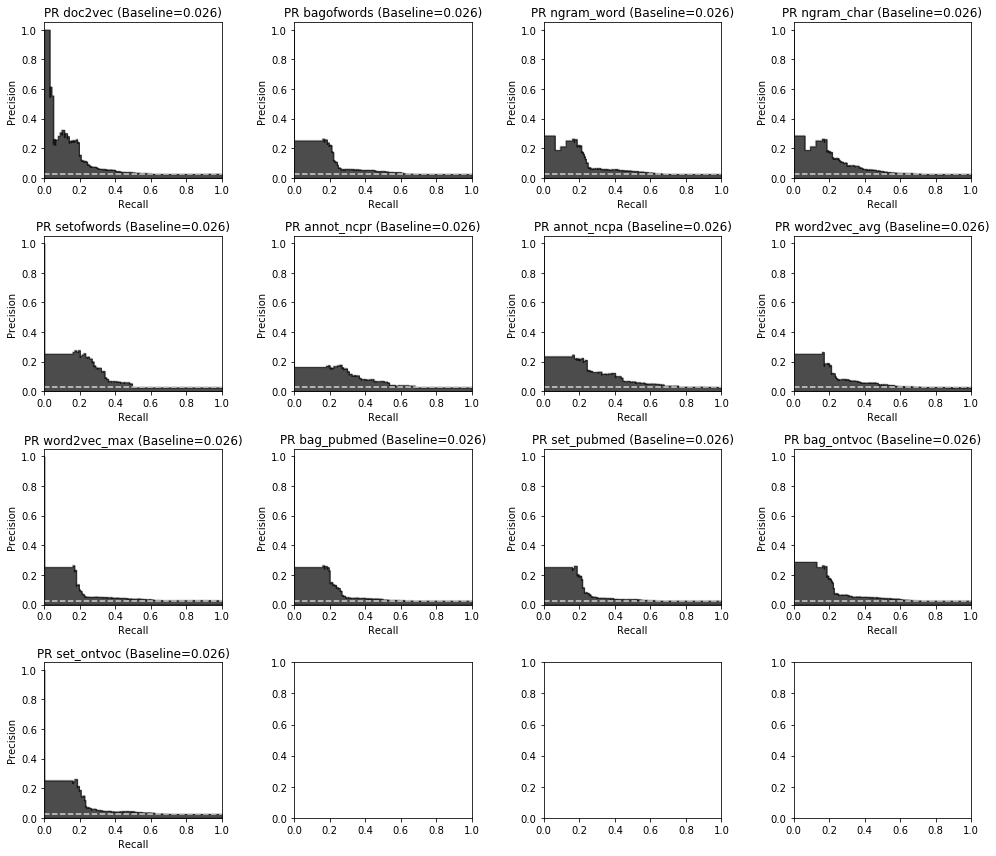

In [41]:
num_plots, plots_per_row, row_width, row_height = (len(methods), 4, 14, 3)
fig,axs = plt.subplots(math.ceil(num_plots/plots_per_row), plots_per_row, squeeze=False)
for method,ax in zip(methods, axs.flatten()):
    
    # Obtaining the values and metrics.
    y_true = pd.DataFrame(true_dict[method]).as_matrix().flatten()
    y_prob = pd.DataFrame(pred_dict[method]).as_matrix().flatten()
    n_pos, n_neg = Counter(y_true)[1], Counter(y_true)[0]
    precision, recall, thresholds = precision_recall_curve(y_true, y_prob)
    baseline = Counter(y_true)[1]/len(y_true) 
    area = auc(recall, precision)
    auc_to_baseline_auc_ratio = area/baseline
    TABLE[method].update({(TAG,"mean_auc"):area, (TAG,"mean_baseline"):baseline, (TAG,"mean_ratio"):auc_to_baseline_auc_ratio})

    # Producing the precision recall curve.
    step_kwargs = ({'step': 'post'} if 'step' in signature(plt.fill_between).parameters else {})
    ax.step(recall, precision, color='black', alpha=0.2, where='post')
    ax.fill_between(recall, precision, alpha=0.7, color='black', **step_kwargs)
    ax.axhline(baseline, linestyle="--", color="lightgray")
    ax.set_xlabel('Recall')
    ax.set_ylabel('Precision')
    ax.set_ylim([0.0, 1.05])
    ax.set_xlim([0.0, 1.0])
    ax.set_title("PR {0} (Baseline={1:0.3f})".format(method, baseline))
    
fig.set_size_inches(row_width, row_height*math.ceil(num_plots/plots_per_row))
fig.tight_layout()
fig.show()
fig.savefig(os.path.join(OUTPUT_DIR,"prcurve_mean_classifier.png"))

### 2.11 Predicting biochemical pathway membership based on mean similarity values.
This section looks at how well the biochemical pathways that a particular gene is a member of can be predicted based on the average similarity between the vector representationt of the phenotype descriptions for that gene and each of the vector representations for other phenotypes associated with genes that belong to that particular pathway. In calculating the average similarity to other genes from a given biochemical pathway, the gene that is currently being classified is not accounted for, to avoid overestimating the performance by including information about the ground truth during classification. This leads to missing information in the case of biochemical pathways that have only one member. This can be accounted for by only limiting the overall dataset to only include genes that belong to pathways that have atleast two genes mapped to them, and only including those pathways, or by removing the missing values before calculating the performance metrics below.

### 2.13 KNN classification for groups or pathways
Only interested in groups that contain more than one gene, and the genes that map to those groups. This is because for other genes, if we consider them then it will be true that that gene belongs to that group in the target vector, but KNN could never predict this becuase when that gene is held out, nothing could provide a vote for that group, because there are zero genes available to be candidates for the K nearest neighbors. 

In [47]:
valid_group_ids = [group for group,id_list in group_id_to_ids.items() if len(id_list)>1]
valid_ids = [i for i in dataset.get_ids() if len(set(valid_group_ids).intersection(set(id_to_group_ids[i])))>0]

# Leave one out predictions.
pred_dict = defaultdict(lambda: defaultdict(dict))
true_dict = defaultdict(lambda: defaultdict(dict))

for method in methods:
    for i in valid_ids:
        ids = [identifier for identifier in valid_ids if identifier!=i]
        # Make the labels just the ID's for that gene instead of pathways or groups, transform votes later.
        X = [vector_dicts[method][identifier] for identifier in ids]
        y = [identifier for identifier in ids]
        neigh = KNeighborsClassifier(n_neighbors=5)
        neigh.fit(X,y)
        probs = neigh.predict_proba([vector_dicts[method][i]])
        # The classes are given in lexicographic order from the predict_proba method.
        # 1. Create a 2D binary array with a row for each group and a column for each gene.
        # 2. Multiply each row of that 2D binary array with the 1D array that has the probability for each gene.
        # 3. Find the sum of each row to get the score specific to each group for this particular gene.
        # 4. Append to the arrays for the true binary classifications and the predictions for each group. 
        ids.sort()
        binary_arr = np.array([[(group_id in id_to_group_ids[x])*1 for x in ids] for group_id in valid_group_ids]) 
        group_probs_by_gene = probs*binary_arr
        group_probs = np.sum(group_probs_by_gene, axis=1)
        for group_index,group_id in enumerate(valid_group_ids):
            pred_dict[method][i][group_id] = group_probs[group_index]
            true_dict[method][i][group_id] = (i in group_id_to_ids[group_id])*1
        #pred_dict[method].extend(group_probs)
        #true_dict[method].extend([(i in group_id_to_ids[group])*1 for group in valid_group_ids])

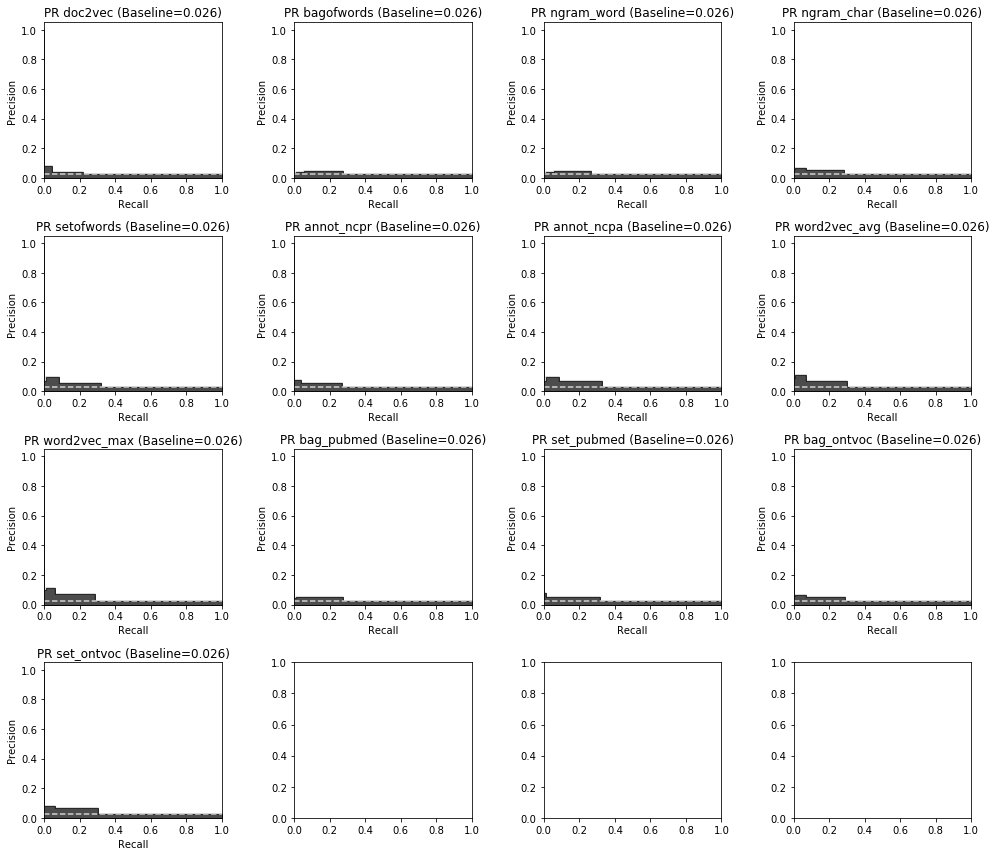

In [49]:
num_plots, plots_per_row, row_width, row_height = (len(methods), 4, 14, 3)
fig,axs = plt.subplots(math.ceil(num_plots/plots_per_row), plots_per_row, squeeze=False)
for method,ax in zip(methods, axs.flatten()):
    
    # Obtaining the values and metrics.
    y_true = pd.DataFrame(true_dict[method]).as_matrix().flatten()
    y_prob = pd.DataFrame(pred_dict[method]).as_matrix().flatten()
    n_pos, n_neg = Counter(y_true)[1], Counter(y_true)[0]
    precision, recall, thresholds = precision_recall_curve(y_true, y_prob)
    baseline = Counter(y_true)[1]/len(y_true) 
    area = auc(recall, precision)
    auc_to_baseline_auc_ratio = area/baseline
    TABLE[method].update({(TAG,"knn_auc"):area, (TAG,"knn_baseline"):baseline, (TAG,"knn_ratio"):auc_to_baseline_auc_ratio})

    # Producing the precision recall curve.
    step_kwargs = ({'step': 'post'} if 'step' in signature(plt.fill_between).parameters else {})
    ax.step(recall, precision, color='black', alpha=0.2, where='post')
    ax.fill_between(recall, precision, alpha=0.7, color='black', **step_kwargs)
    ax.axhline(baseline, linestyle="--", color="lightgray")
    ax.set_xlabel('Recall')
    ax.set_ylabel('Precision')
    ax.set_ylim([0.0, 1.05])
    ax.set_xlim([0.0, 1.0])
    ax.set_title("PR {0} (Baseline={1:0.3f})".format(method, baseline))
    
fig.set_size_inches(row_width, row_height*math.ceil(num_plots/plots_per_row))
fig.tight_layout()
fig.show()
fig.savefig(os.path.join(OUTPUT_DIR,"prcurve_knn_classifier.png"))

### 2.12 Summarizing the results for this notebook

In [ ]:
results = pd.DataFrame(TABLE).transpose()
results.to_csv(os.path.join(OUTPUT_DIR,"full_table.csv"))
results